# Flask App Metrics Analysis

This notebook analyzes the metrics data collected from the Flask application running in Kubernetes. We'll visualize how different metrics change over time:

- Number of instances (pod count)
- CPU Usage
- Requests per second
- Service time
- Workload (arrival rate of requests)

The visualization will help us understand how these metrics relate to each other and identify patterns in the system's behavior.

In [1]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
def plot_metrics(file_path, title):
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extract app name
    app_name = data['app_name']
    print(f"Analyzing data for: {app_name}")

    # Convert to DataFrame
    df = pd.DataFrame(data['history'])
    print(f"Loaded {len(df)} data points")

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Use elapsed_seconds as index for plotting
    df_plot = df.copy()
    df_plot.set_index('elapsed_seconds', inplace=True)

    # Main time series plot (takes up most of the space)
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
    
    ax1.set_title(title, fontsize=14, fontweight='bold')

    # Color definitions for better visual distinction
    colors = {
        'cpu_usage': 'tab:red',
        'instances': 'tab:blue',
        'completed_requests': 'tab:green',
        'mean_request_time': 'tab:purple',
        'workload': 'tab:orange',
        'gateway_mean_response_time': 'tab:brown',
        'jmeter_response_time': 'tab:pink'
    }

    # Plot CPU usage on the first axis
    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_ylabel('CPU Usage', color=colors['cpu_usage'])
    ax1.plot(df_plot.index, df_plot['cpu_usage'], color=colors['cpu_usage'], marker='o', markersize=4, label='CPU Usage')
    ax1.tick_params(axis='y', labelcolor=colors['cpu_usage'])

    # Create second y-axis for instances
    ax2 = ax1.twinx()
    ax2.set_ylabel('Instances', color=colors['instances'])
    ax2.plot(df_plot.index, df_plot['instances'], color=colors['instances'], marker='s', linestyle='--', 
            markersize=5, label='Instances')
    ax2.tick_params(axis='y', labelcolor=colors['instances'])
    ax2.set_ylim(0, max(df_plot['instances']) + 1)

    # Create third y-axis for both workload and completed requests
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Requests per Second', color='orange')
    
    # Plot completed requests
    ax3.plot(df_plot.index, df_plot['requests_per_second'], color=colors['completed_requests'], 
            marker='^', linestyle='-.', markersize=5, label='Completed Req/s')
    
    # Plot workload if available
    if 'workload' in df_plot.columns:
        ax3.plot(df_plot.index, df_plot['workload'], color=colors['workload'], 
                marker='d', linestyle='-', markersize=5, label='Workload')
        max_rate = max(df_plot['workload'].max() if not df_plot['workload'].empty else 0,
                      df_plot['requests_per_second'].max() if not df_plot['requests_per_second'].empty else 0)
        ax3.set_ylim(0, max_rate * 1.1)
    else:
        print("Warning: 'workload' metric not found in data")
        ax3.set_ylim(0, df_plot['requests_per_second'].max() * 1.1)
    
    # Create fourth y-axis for service time, gateway response time, and JMeter response time
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))
    ax4.set_ylabel('Time (s)', color=colors['mean_request_time'])
    ax4.plot(df_plot.index, df_plot['mean_request_time'], color=colors['mean_request_time'], 
            marker='*', linestyle=':', markersize=6, label='Service Time')
    ax4.tick_params(axis='y', labelcolor=colors['mean_request_time'])
    
    # Add gateway response time to the same axis if available
    if 'gateway_mean_response_time' in df_plot.columns:
        ax4.plot(df_plot.index, df_plot['gateway_mean_response_time'], 
                color=colors['gateway_mean_response_time'], 
                marker='x', linestyle='--', markersize=6, label='Gateway Response Time')

    # Create a combined legend for main plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    
    lines = lines1 + lines2 + lines3 + lines4
    labels = labels1 + labels2 + labels3 + labels4
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Add grid for better readability
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Analyzing data for: flask-app-1
Loaded 5 data points


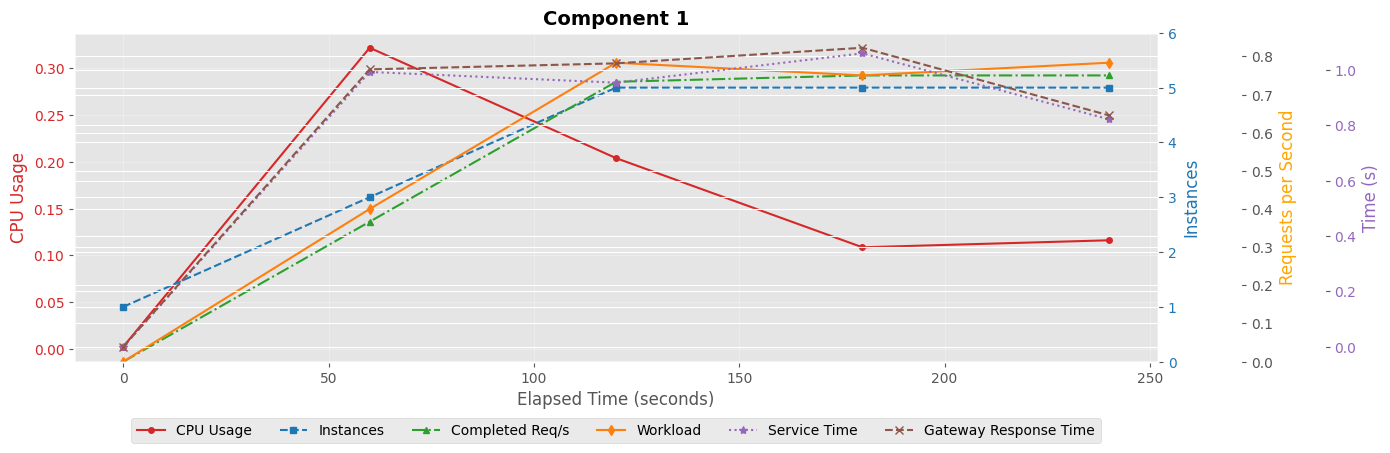

In [3]:
file_path = 'flask-app-1_instance_history.json'
plot_metrics(file_path, 'Component 1')

Analyzing data for: flask-app-2
Loaded 5 data points


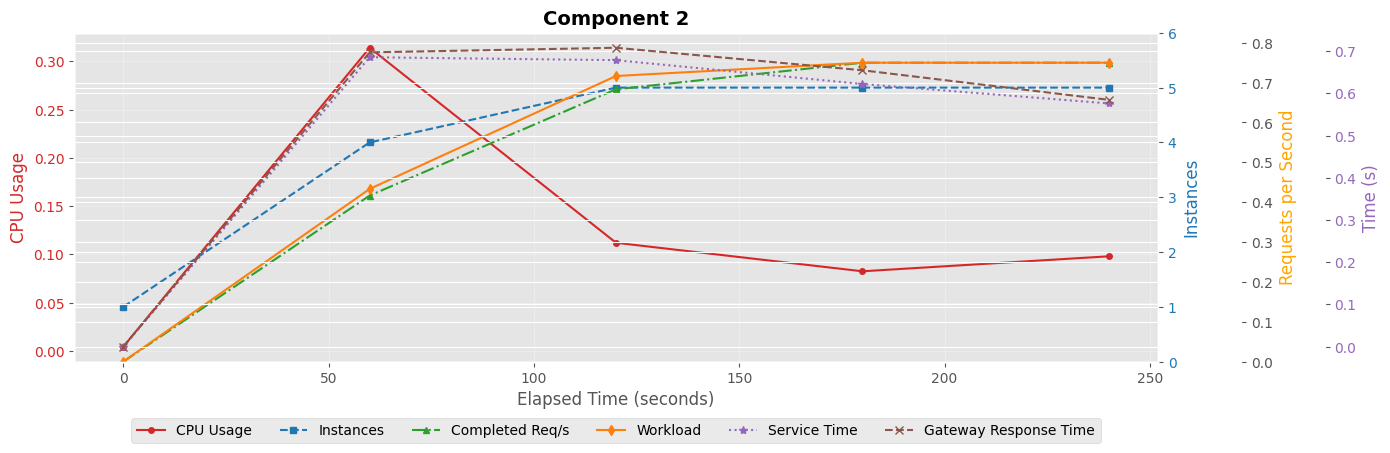

In [4]:
file_path = 'flask-app-2_instance_history.json'
plot_metrics(file_path, 'Component 2')

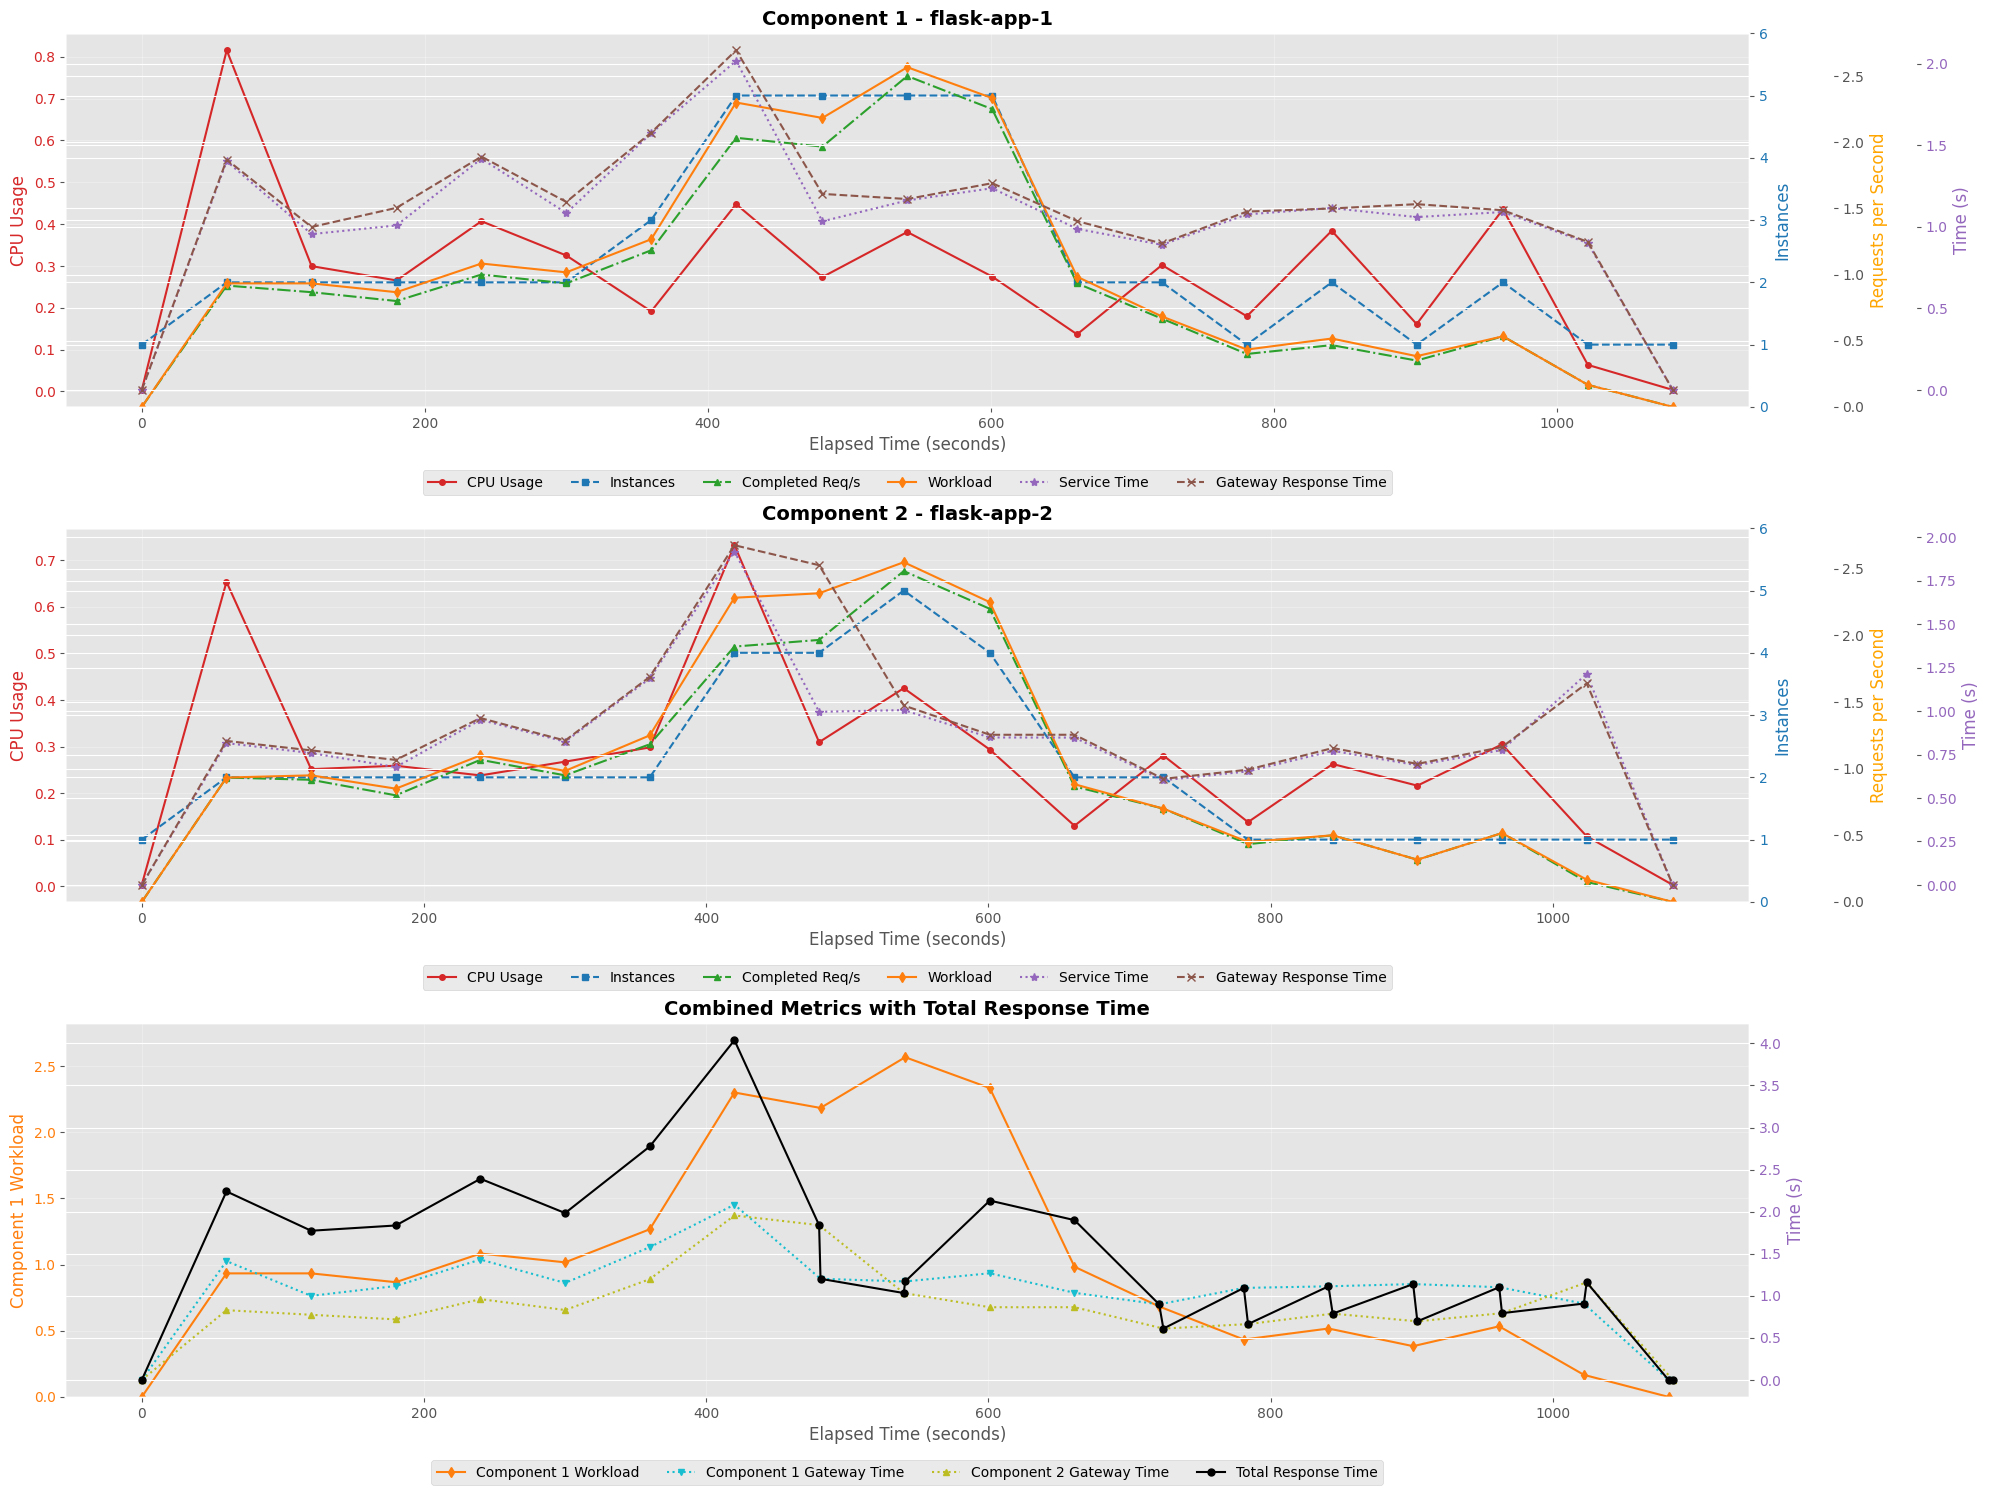

In [49]:
def plot_comparison_with_total_response_time(file_path1, file_path2):
    """
    Create a comparison plot with 3 subplots:
    1. Component 1 metrics
    2. Component 2 metrics  
    3. Combined metrics with total response time
    """
    
    # Load both files
    with open(file_path1, 'r') as file1:
        data1 = json.load(file1)
    with open(file_path2, 'r') as file2:
        data2 = json.load(file2)
    
    df1 = pd.DataFrame(data1['history'])
    df2 = pd.DataFrame(data2['history'])
    
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
    
    df1_plot = df1.copy().set_index('elapsed_seconds')
    df2_plot = df2.copy().set_index('elapsed_seconds')
    
    # Calculate total response time (sum of gateway response times)
    df1['elapsed_seconds'] = pd.to_numeric(df1['elapsed_seconds'], errors='coerce')
    df2['elapsed_seconds'] = pd.to_numeric(df2['elapsed_seconds'], errors='coerce')
    
    gt1 = df1.set_index('elapsed_seconds').get('gateway_mean_response_time', pd.Series(dtype=float))
    gt2 = df2.set_index('elapsed_seconds').get('gateway_mean_response_time', pd.Series(dtype=float))
    total_response_time = gt1.add(gt2, fill_value=0)
    
    # Color definitions
    colors = {
        'cpu_usage': 'tab:red',
        'instances': 'tab:blue', 
        'completed_requests': 'tab:green',
        'mean_request_time': 'tab:purple',
        'workload': 'tab:orange',
        'gateway_mean_response_time': 'tab:brown',
        'total_response_time': 'black'
    }
    
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(20, 15))
    
    # Helper function to plot metrics for each component
    def plot_component_metrics(df_plot, subplot_pos, title, app_name):
        ax1 = plt.subplot(3, 1, subplot_pos)
        ax1.set_title(f'{title} - {app_name}', fontsize=14, fontweight='bold')
        
        # CPU Usage
        ax1.set_xlabel('Elapsed Time (seconds)')
        ax1.set_ylabel('CPU Usage', color=colors['cpu_usage'])
        ax1.plot(df_plot.index, df_plot['cpu_usage'], color=colors['cpu_usage'], marker='o', markersize=4, label='CPU Usage')
        ax1.tick_params(axis='y', labelcolor=colors['cpu_usage'])
        
        # Instances
        ax2 = ax1.twinx()
        ax2.set_ylabel('Instances', color=colors['instances'])
        ax2.plot(df_plot.index, df_plot['instances'], color=colors['instances'], marker='s', linestyle='--', markersize=5, label='Instances')
        ax2.tick_params(axis='y', labelcolor=colors['instances'])
        ax2.set_ylim(0, max(df_plot['instances']) + 1)
        
        # Requests per second and workload
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('Requests per Second', color='orange')
        ax3.plot(df_plot.index, df_plot['requests_per_second'], color=colors['completed_requests'], marker='^', linestyle='-.', markersize=5, label='Completed Req/s')
        
        if 'workload' in df_plot.columns:
            ax3.plot(df_plot.index, df_plot['workload'], color=colors['workload'], marker='d', linestyle='-', markersize=5, label='Workload')
            max_rate = max(df_plot['workload'].max() if not df_plot['workload'].empty else 0, df_plot['requests_per_second'].max() if not df_plot['requests_per_second'].empty else 0)
            ax3.set_ylim(0, max_rate * 1.1)
        else:
            ax3.set_ylim(0, df_plot['requests_per_second'].max() * 1.1)
        
        # Service time and gateway response time
        ax4 = ax1.twinx()
        ax4.spines['right'].set_position(('outward', 120))
        ax4.set_ylabel('Time (s)', color=colors['mean_request_time'])
        ax4.plot(df_plot.index, df_plot['mean_request_time'], color=colors['mean_request_time'], marker='*', linestyle=':', markersize=6, label='Service Time')
        ax4.tick_params(axis='y', labelcolor=colors['mean_request_time'])
        
        if 'gateway_mean_response_time' in df_plot.columns:
            ax4.plot(df_plot.index, df_plot['gateway_mean_response_time'], color=colors['gateway_mean_response_time'], marker='x', linestyle='--', markersize=6, label='Gateway Response Time')
        
        # Create legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        lines4, labels4 = ax4.get_legend_handles_labels()
        
        lines = lines1 + lines2 + lines3 + lines4
        labels = labels1 + labels2 + labels3 + labels4
        ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
        
        ax1.grid(True, alpha=0.3)
        return ax1
    
    # Plot Component 1
    plot_component_metrics(df1_plot, 1, 'Component 1', data1['app_name'])
    
    # Plot Component 2  
    plot_component_metrics(df2_plot, 2, 'Component 2', data2['app_name'])
    
    # Plot Combined metrics with total response time
    ax1 = plt.subplot(3, 1, 3)
    ax1.set_title('Combined Metrics with Total Response Time', fontsize=14, fontweight='bold')
    
    # Component 1 workload only
    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_ylabel('Component 1 Workload', color=colors['workload'])
    if 'workload' in df1_plot.columns:
        ax1.plot(df1_plot.index, df1_plot['workload'], color=colors['workload'], marker='d', linestyle='-', markersize=5, label='Component 1 Workload')
        ax1.set_ylim(0, df1_plot['workload'].max() * 1.1)
    ax1.tick_params(axis='y', labelcolor=colors['workload'])
    
    # Response times - individual components and total
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time (s)', color=colors['mean_request_time'])
    
    # Individual component gateway response times
    if 'gateway_mean_response_time' in df1_plot.columns:
        ax2.plot(df1_plot.index, df1_plot['gateway_mean_response_time'], color='tab:cyan', marker='v', linestyle=':', markersize=4, label='Component 1 Gateway Time')
    if 'gateway_mean_response_time' in df2_plot.columns:
        ax2.plot(df2_plot.index, df2_plot['gateway_mean_response_time'], color='tab:olive', marker='^', linestyle=':', markersize=4, label='Component 2 Gateway Time')
    
    # Total response time
    ax2.plot(total_response_time.index, total_response_time.values, color=colors['total_response_time'], marker='o', linestyle='-', markersize=5, label='Total Response Time')
    ax2.tick_params(axis='y', labelcolor=colors['mean_request_time'])

    # Create legend for combined plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)

    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Generate the comparison plot
plot_comparison_with_total_response_time(
    'flask-app-1_instance_history.json',
    'flask-app-2_instance_history.json'
)